In [1]:
# ================================================================
# 📊 TELECOM CHURN PROJECT – FEATURE ENGINEERING (FINAL WORKING VERSION)
# ================================================================

import pandas as pd
import numpy as np

# ================================================================
# 1️⃣ LOAD AND CLEAN DATA
# ================================================================
data_path = "/kaggle/input/cleaned-telecom-subscriptions-2/Cleaned_Telecom_Subscriptions.csv"
df = pd.read_csv(data_path)

print(f"✅ Loaded dataset: {df.shape[0]} rows, {df.shape[1]} columns")
print("Columns:", df.columns.tolist())

# --- Clean numeric column ---
def clean_numeric(col):
    """Remove spaces, commas, and convert to float"""
    return (
        col.astype(str)
        .str.replace(r"[^0-9.\-]", "", regex=True)
        .replace("", np.nan)
        .astype(float)
    )

if 'value' in df.columns:
    df['value'] = clean_numeric(df['value'])

# --- Normalize month column ---
if 'month' in df.columns:
    df['month'] = df['month'].astype(str).str.strip().str.title()

    # If month is textual (like "January"), convert to number
    try:
        df['month_num'] = pd.to_datetime(df['month'], format='%B').dt.month
    except Exception:
        # Fallback: try abbreviated format ("Jan", "Feb", etc.)
        df['month_num'] = pd.to_datetime(df['month'], format='%b', errors='coerce').dt.month

# --- Create a valid 'date' column ---
if 'year' in df.columns and 'month_num' in df.columns:
    df['year'] = clean_numeric(df['year']).astype(int)
    df['month_num'] = df['month_num'].fillna(1).astype(int)
    df['date'] = pd.to_datetime(
        dict(year=df['year'], month=df['month_num'], day=1), errors='coerce'
    )
else:
    raise ValueError("❌ Missing 'year' or 'month' column for date creation!")

# --- Fill missing values safely using transform ---
df['value'] = (
    df.groupby(['service_provider', 'circle'])['value']
    .transform(lambda x: x.fillna(method='ffill').fillna(method='bfill'))
)

# --- Drop unnecessary columns ---
df.drop(columns=['unit', 'notes'], inplace=True, errors='ignore')

print("🧹 Data cleaned and 'date' column successfully created.")


# ================================================================
# 2️⃣ TEMPORAL FEATURES
# ================================================================
def create_temporal_features(df):
    df_temp = df.copy()

    # Lag Features
    for lag in [1, 3, 6, 12]:
        df_temp[f'subscribers_lag_{lag}'] = (
            df_temp.groupby(['service_provider', 'circle'])['value']
            .shift(lag)
        )

    # Growth Rates
    df_temp['mom_growth'] = (
        df_temp.groupby(['service_provider', 'circle'])['value']
        .pct_change()
    )
    df_temp['yoy_growth'] = (
        df_temp.groupby(['service_provider', 'circle'])['value']
        .pct_change(12)
    )

    # Rolling Volatility
    for window in [3, 6, 12]:
        df_temp[f'growth_volatility_{window}'] = (
            df_temp.groupby(['service_provider', 'circle'])['mom_growth']
            .rolling(window)
            .std()
            .reset_index(level=[0, 1], drop=True)
        )

    # Trend (12-month slope)
    def calc_trend(series):
        y = series.values
        x = np.arange(len(y))
        valid = ~np.isnan(y)
        if valid.sum() < 3:
            return np.nan
        return np.polyfit(x[valid], y[valid], 1)[0]

    df_temp['trend_12m'] = (
        df_temp.groupby(['service_provider', 'circle'])['value']
        .rolling(12)
        .apply(calc_trend, raw=False)
        .reset_index(level=[0, 1], drop=True)
    )

    print("✅ Temporal features created.")
    return df_temp


# ================================================================
# 3️⃣ COMPETITIVE FEATURES
# ================================================================
def create_competitive_features(df):
    df_comp = df.copy()

    # Total subscribers in circle per month
    df_comp['total_circle_subscribers'] = df_comp.groupby(['circle', 'date'])['value'].transform('sum')

    # Market share
    df_comp['market_share'] = df_comp['value'] / df_comp['total_circle_subscribers']

    # Market Rank
    df_comp['market_rank'] = (
        df_comp.groupby(['circle', 'date'])['market_share']
        .rank(ascending=False)
    )

    # Gap from Leader
    leader_share = df_comp.groupby(['circle', 'date'])['market_share'].transform('max')
    df_comp['share_gap_leader'] = leader_share - df_comp['market_share']

    # Relative Performance
    circle_avg = df_comp.groupby(['circle', 'date'])['value'].transform('mean')
    df_comp['relative_performance'] = df_comp['value'] / circle_avg

    print("✅ Competitive features created.")
    return df_comp


# ================================================================
# 4️⃣ GEOGRAPHIC & BUSINESS FEATURES
# ================================================================
def create_geographic_features(df):
    df_geo = df.copy()

    metros = ['Delhi', 'Mumbai', 'Chennai', 'Kolkata', 'Hyderabad', 'Bangalore']
    df_geo['circle_type'] = df_geo['circle'].apply(
        lambda x: 'Metro' if x in metros else 'Non-Metro'
    )

    df_geo['is_wireless'] = df_geo['type_of_connection'].str.lower().eq('wireless').astype(int)

    total_market = df_geo.groupby('circle')['value'].transform('sum')
    df_geo['market_size_category'] = df_geo['circle'].map(
        df_geo.groupby('circle')['value'].sum()
    )

    op_diversity = df_geo.groupby('service_provider')['circle'].transform('nunique')
    df_geo['operator_geographic_diversity'] = df_geo['service_provider'].map(
        df_geo.groupby('service_provider')['circle'].nunique()
    )

    print("✅ Geographic & business features created.")
    return df_geo


# ================================================================
# 5️⃣ RUN PIPELINE
# ================================================================
def run_feature_engineering(df):
    df1 = create_temporal_features(df)
    df2 = create_competitive_features(df1)
    df3 = create_geographic_features(df2)
    df3 = df3.fillna(0)
    print(f"🎯 Feature engineering complete! Final shape: {df3.shape}")
    return df3


df_features = run_feature_engineering(df)


# ================================================================
# 6️⃣ SAVE OUTPUT
# ================================================================
output_path = "/kaggle/working/Telecom_Features.csv"
df_features.to_csv(output_path, index=False)
print(f"📁 Saved feature-engineered dataset to: {output_path}")

df_features.head()


/tmp/ipykernel_13/139793593.py:12: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path)


✅ Loaded dataset: 70728 rows, 8 columns
Columns: ['year', 'month', 'circle', 'type_of_connection', 'service_provider', 'value', 'unit', 'notes']


/tmp/ipykernel_13/139793593.py:54: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .transform(lambda x: x.fillna(method='ffill').fillna(method='bfill'))


🧹 Data cleaned and 'date' column successfully created.


/tmp/ipykernel_13/139793593.py:79: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  .pct_change()
/tmp/ipykernel_13/139793593.py:83: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  .pct_change(12)


✅ Temporal features created.
✅ Competitive features created.
✅ Geographic & business features created.
🎯 Feature engineering complete! Final shape: (70728, 27)
📁 Saved feature-engineered dataset to: /kaggle/working/Telecom_Features.csv


,year,month,circle,type_of_connection,service_provider,value,month_num,date,subscribers_lag_1,subscribers_lag_3,...,trend_12m,total_circle_subscribers,market_share,market_rank,share_gap_leader,relative_performance,circle_type,is_wireless,market_size_category,operator_geographic_diversity
0,2025,April,Andhra Pradesh,wireless,Bharti Airtel (Including Tata Tele.),33965795.0,4,2025-04-01,0.0,0.0,...,0.0,86754693.0,0.391515,1.0,0.000000,6.264246,Non-Metro,1,1.481718e+10,23
1,2025,April,Assam,wireless,Bharti Airtel (Including Tata Tele.),12314102.0,4,2025-04-01,0.0,0.0,...,0.0,26794099.0,0.459583,1.0,0.000000,7.353322,Non-Metro,1,3.819044e+09,23
2,2025,April,Bihar,wireless,Bharti Airtel (Including Tata Tele.),40967773.0,4,2025-04-01,0.0,0.0,...,0.0,97994908.0,0.418060,2.0,0.011617,6.688964,Non-Metro,1,1.457673e+10,23
3,2025,April,Delhi,wireless,Bharti Airtel (Including Tata Tele.),18877637.0,4,2025-04-01,0.0,0.0,...,0.0,63457000.0,0.297487,2.0,0.015992,4.759793,Metro,1,9.914558e+09,23
4,2025,April,Gujarat,wireless,Bharti Airtel (Including Tata Tele.),12401101.0,4,2025-04-01,0.0,0.0,...,0.0,67527862.0,0.183644,3.0,0.267338,2.938307,Non-Metro,1,1.214509e+10,23


Dataset shape: (70728, 27)
                                                        mean  \
year                                             2016.026298   
value                                         5766721.695513   
month_num                                           6.341011   
date                           2016-06-20 20:51:33.043773184   
subscribers_lag_1                             5717644.920487   
subscribers_lag_3                             5661532.520716   
subscribers_lag_6                             5578705.878227   
subscribers_lag_12                            5402516.188047   
mom_growth                                               inf   
yoy_growth                                               inf   
growth_volatility_3                                15.557487   
growth_volatility_6                                19.859632   
growth_volatility_12                               25.456282   
trend_12m                                      -43556.188557   
total_circle_

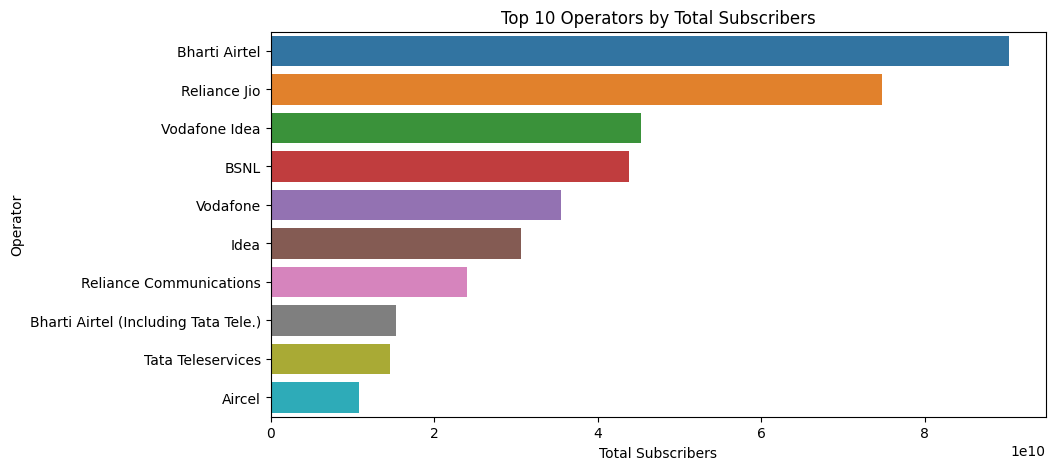

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


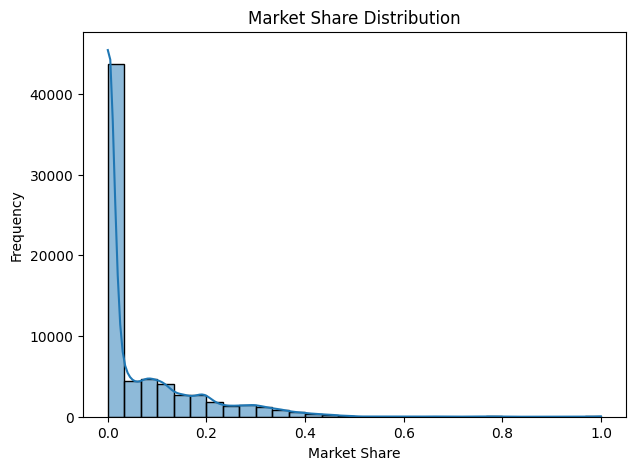

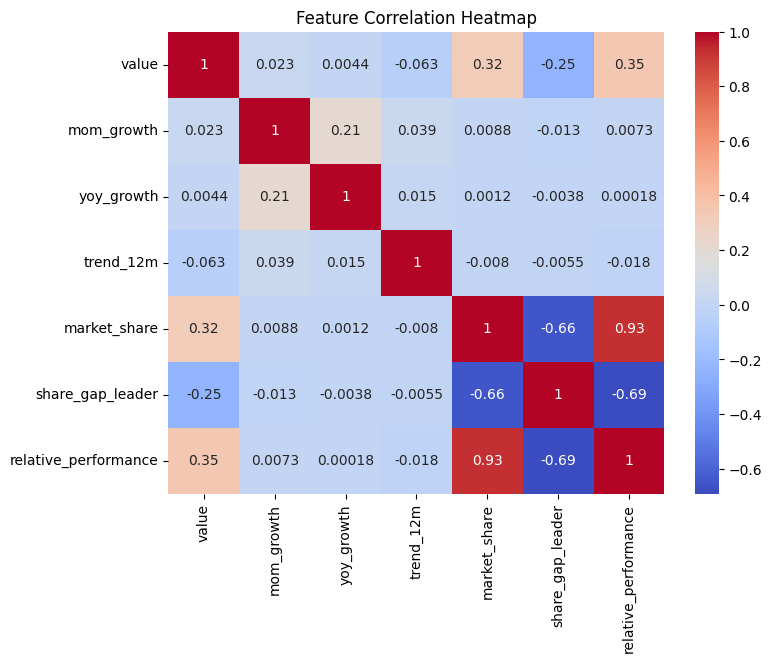

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# Basic feature insights
print(f"Dataset shape: {df_features.shape}")
print(df_features.describe().T[['mean', 'std', 'min', 'max']])

# Top operators by total subscribers
top_ops = (
    df_features.groupby('service_provider')['value']
    .sum()
    .sort_values(ascending=False)
    .head(10)
)
plt.figure(figsize=(10,5))
sns.barplot(x=top_ops.values, y=top_ops.index)
plt.title("Top 10 Operators by Total Subscribers")
plt.xlabel("Total Subscribers")
plt.ylabel("Operator")
plt.show()

# Market share distribution
plt.figure(figsize=(7,5))
sns.histplot(df_features['market_share'], bins=30, kde=True)
plt.title("Market Share Distribution")
plt.xlabel("Market Share")
plt.ylabel("Frequency")
plt.show()

# Correlation heatmap for key features
key_feats = [
    'value', 'mom_growth', 'yoy_growth', 'trend_12m',
    'market_share', 'share_gap_leader', 'relative_performance'
]
plt.figure(figsize=(8,6))
sns.heatmap(df_features[key_feats].corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()
